# Basic Analysis

This part mainly focus on the analysis of overall situation of the dataset and some of the detailed description on specific features, including charge_degree, legal_status, raw_score, decile_score, recidivist, sex, race, age, r_days_from_arrest, rec_supervision_level. 

### 0. Configuration and Initialization
The compas, summary and people tables are the main focus of this project based on the main objective. Tables will be read from a SQL database and processed with dataframe datatypes. 

In [51]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

conn = sqlite3.connect('./data/compas.db')
c = conn.cursor()

In [29]:
compas = pd.read_sql_query("SELECT * FROM compas", conn)
charge = pd.read_sql_query("SELECT * FROM charge", conn)
casearrest = pd.read_sql_query("SELECT * FROM casearrest", conn)
people = pd.read_sql_query("SELECT * FROM people", conn)

In [71]:
print(compas.columns)
print(charge.columns)
print(casearrest.columns)
print(people.columns)

Index(['id', 'first', 'last', 'compas_person_id', 'compas_case_id',
       'compas_assessment_id', 'agency_text', 'scale_set', 'assessment_reason',
       'legal_status', 'custody_status', 'marital_status', 'screening_date',
       'rec_supervision_level', 'rec_supervision_level_text', 'score_text',
       'scale_id', 'type_of_assessment', 'raw_score', 'decile_score',
       'person_id'],
      dtype='object')
Index(['id', 'case_type', 'case_number', 'filing_date', 'offense_date',
       'charge_number', 'charge_degree', 'charge', 'date_charge_filed',
       'filing_type', 'filing_agency', 'name', 'days_since_compas', 'statute',
       'person_id'],
      dtype='object')
Index(['id', 'name', 'case_number', 'arrest_id', 'arrest_date',
       'charge_degree', 'days_since_compas_arrest', 'person_id'],
      dtype='object')
Index(['id', 'name', 'first', 'last', 'sex', 'race', 'dob', 'age', 'age_cat',
       'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'compas_screening_date

### 1. Overall situation

The COMPAS system records the risk of violence, recidivism or failure to appear respectively for a person. 

In [12]:
compas['type_of_assessment'].unique()

array(['Risk of Violence', 'Risk of Recidivism',
       'Risk of Failure to Appear'], dtype=object)

There's a little difference between compas person id and person id, we will use person id as default index for identification. Then, 11757 people are recorded in the dataset. 

In [10]:
people['id'].unique().shape

(11757,)

In [5]:
print(compas['person_id'].unique().shape, compas['compas_person_id'].unique().shape)

(11757,) (11779,)


The compas case id is almost the same as person id, each people have 3 cases with same case id, recording the assessment of risk of violence, recidivism, and failure to appear. 

In [24]:
compas['compas_case_id'].unique().shape

(12094,)

In [25]:
compas['compas_case_id'].shape

(37578,)

148,086 charge and 128,183 arrest in total. 

In [27]:
charge['id'].unique().shape

(148086,)

In [28]:
charge['person_id'].unique().shape

(11142,)

In [31]:
casearrest['id'].unique().shape

(128183,)

In [30]:
casearrest['person_id'].unique().shape

(10963,)

Based on the date of the arrest and charge, most of the cases are from 2013-2020. Also noted that a false date appears in case arrest, which should be cleaned later. 

<AxesSubplot:xlabel='offense_date'>

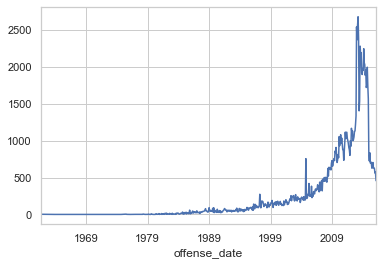

In [52]:
grouped_month = charge.groupby(pd.to_datetime(charge['offense_date']).dt.to_period('M')).count()
grouped_month['id'].plot()

<AxesSubplot:xlabel='arrest_date'>

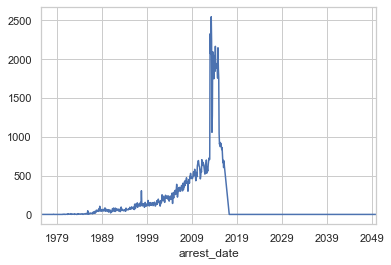

In [53]:
grouped_month = casearrest.groupby(pd.to_datetime(casearrest['arrest_date']).dt.to_period('M')).count()
grouped_month['id'].plot()

### 2. Detail description of specific features

#### 2.1 charge_degree

14 degrees of charges in compas record and 17 degrees in charge record, ignoring the 'XXXXXX' which may means no record. The different degrees are '0', 'M3' and 'TC4'. If we ignore the degrees with less than 100 record, both of the record will be the same. 

In [60]:
charge['charge_degree'].value_counts()

(0)           50656
(F3)          30533
(M1)          28003
(M2)          22295
(F2)           8943
(MO3)          3537
(F1)           1992
(TCX)           895
(NI0)           496
(F7)            430
(CO3)           128
(TC4)            90
(F5)             32
(F6)             22
(X)              14
(CT)             13
XXXXXXXXXX        4
(M3)              3
Name: charge_degree, dtype: int64

In [62]:
people['c_charge_degree'].value_counts()

(F3)     5913
(M1)     2831
(F2)      953
(M2)      857
(F1)      221
(F7)      128
(MO3)      83
(F6)       10
(NI0)       8
(F5)        7
(X)         1
(CT)        1
(TCX)       1
(CO3)       1
Name: c_charge_degree, dtype: int64

#### 2.2 legal Status

All of the record in COMPAS are in pretrail status. 

In [66]:
compas['legal_status'].value_counts()

Pretrial    37578
Name: legal_status, dtype: int64

#### 2.3 raw score & decile score

All of the decile score are scaled from raw score. Since this project only focus on recidivism, the following histogram is filtered with risk of recidivism. 

<AxesSubplot:>

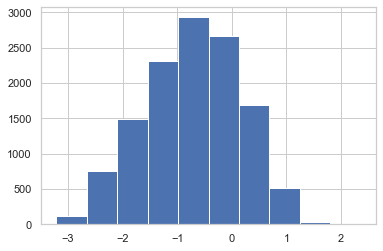

In [69]:
compas[compas['type_of_assessment']=='Risk of Recidivism']['raw_score'].hist()

<AxesSubplot:>

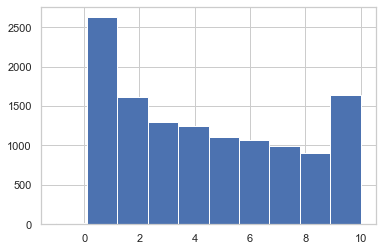

In [70]:
compas[compas['type_of_assessment']=='Risk of Recidivism']['decile_score'].hist()

#### 2.4 Revidicist

62% of the people do not recidivate and 31% of them recidivated. The rest of them are lack of record and will be cleaned. 

In [72]:
print(people['is_recid'].value_counts())
print(people['is_recid'].value_counts()/people['is_recid'].shape[0])

 0    7335
 1    3703
-1     719
Name: is_recid, dtype: int64
 0    0.623884
 1    0.314961
-1    0.061155
Name: is_recid, dtype: float64


#### 2.5 Sex

79% of the people in the record are male and 21% are female.

In [75]:
print(people['sex'].value_counts())
print(people['sex'].value_counts()/people['sex'].shape[0])

Male      9336
Female    2421
Name: sex, dtype: int64
Male      0.79408
Female    0.20592
Name: sex, dtype: float64


#### 2.6 Race
49% of them are African-American, 25% are Caucasian. The rest of the races are Hispanic, Asian, Native American and other. 

In [76]:
print(people['race'].value_counts())
print(people['race'].value_counts()/people['race'].shape[0])

African-American    5813
Caucasian           4085
Hispanic            1100
Other                661
Asian                 58
Native American       40
Name: race, dtype: int64
African-American    0.494429
Caucasian           0.347453
Hispanic            0.093561
Other               0.056222
Asian               0.004933
Native American     0.003402
Name: race, dtype: float64


#### 2.7 Age

<AxesSubplot:xlabel='age', ylabel='Percent'>

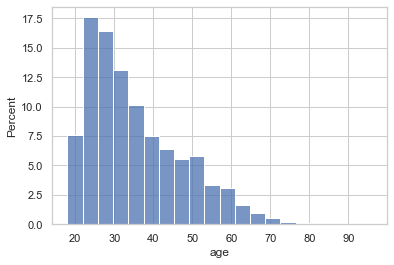

In [82]:
sns.histplot(data=people, x="age", stat = 'percent', bins = 20)

#### 2.8 Rec_supervision_level

59% of them are under 1 level of supervision, 19% are level 2, 14% are level 3 and 9% are level 4.

In [92]:
print(compas[compas['type_of_assessment']=='Risk of Recidivism']['rec_supervision_level'].value_counts())
print(compas[compas['type_of_assessment']=='Risk of Recidivism']['rec_supervision_level'].value_counts()/compas[compas['type_of_assessment']=='Risk of Recidivism']['rec_supervision_level'].shape[0])

1    7400
2    2334
3    1712
4    1080
Name: rec_supervision_level, dtype: int64
1    0.590771
2    0.186332
3    0.136676
4    0.086221
Name: rec_supervision_level, dtype: float64
